In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def load_and_concat_datasets(parent_folder, channels):
    datasets = [
        xr.open_dataset(f'{parent_folder}/{channel}')[channel.split('.')[0]]
        for channel in channels
    ]
    ds_combined = xr.concat(datasets, dim='channels')
    return ds_combined

def find_min_max_across_channels(ds_combined):
    mins = [np.nanmin(ds_combined[i].values) for i in range(ds_combined.shape[0])]
    maxs = [np.nanmax(ds_combined[i].values) for i in range(ds_combined.shape[0])]
    return np.nanmin(mins), np.nanmax(maxs)

def rescale_data(data, global_min, global_max):
    return 255 * (data - global_min) / (global_max - global_min)

In [3]:
parent_folder = '/Users/rashmilsinha/Downloads/Sentinel-lite/sentinel/'
channels_radiance = [
    'S1_radiance_in.nc', 'S2_radiance_in.nc', 'S3_radiance_in.nc',
    'S4_radiance_in.nc', 'S5_radiance_in.nc', 'S6_radiance_in.nc'
]
channels_thermal = ['S7_BT_in.nc', 'S8_BT_in.nc', 'S9_BT_in.nc']
channels = channels_radiance + channels_thermal

In [4]:
ds_combined = load_and_concat_datasets(parent_folder, channels)

global_min, global_max = find_min_max_across_channels(ds_combined)

rescaled_data = xr.apply_ufunc(
    rescale_data,
    ds_combined,
    kwargs={'global_min': global_min, 'global_max': global_max},
    vectorize=True
)

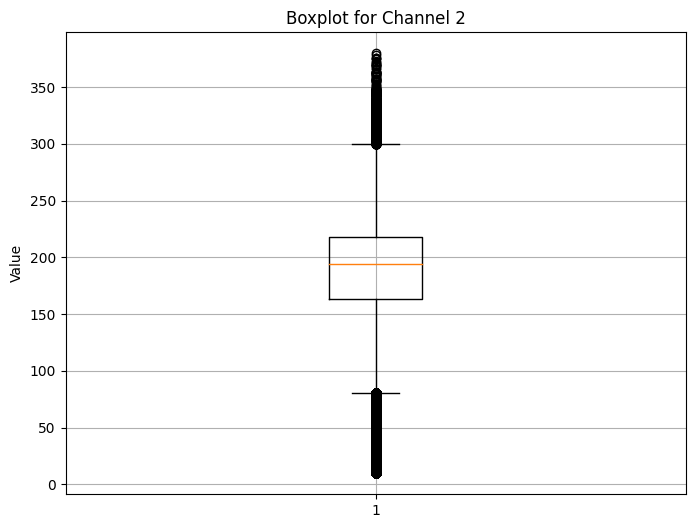

In [5]:
def plot_boxplot_for_channel(ds_combined, channel_idx):
    channel_data = ds_combined[channel_idx].values.flatten()
    valid_data = channel_data[~np.isnan(channel_data)]
    
    plt.figure(figsize=(8, 6))
    plt.boxplot(valid_data)
    plt.title(f"Boxplot for Channel {channel_idx + 1}")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()

# Plotting for the second channel
plot_boxplot_for_channel(ds_combined, 1)


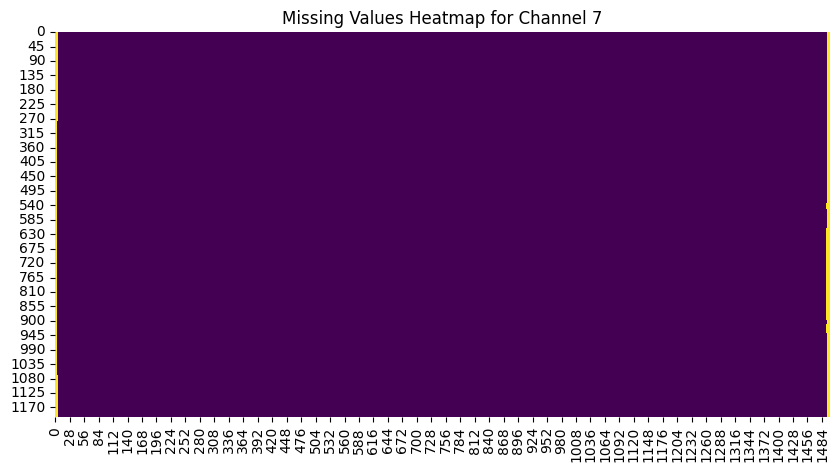

In [6]:
import seaborn as sns

def plot_missing_values_heatmap(ds_combined, channel_idx):
    channel_data = ds_combined[channel_idx].values
    missing_values = np.isnan(channel_data)
    
    plt.figure(figsize=(10, 5))
    sns.heatmap(missing_values, cbar=False, cmap='viridis')
    plt.title(f"Missing Values Heatmap for Channel {channel_idx + 1}")
    plt.show()

plot_missing_values_heatmap(ds_combined, 6)


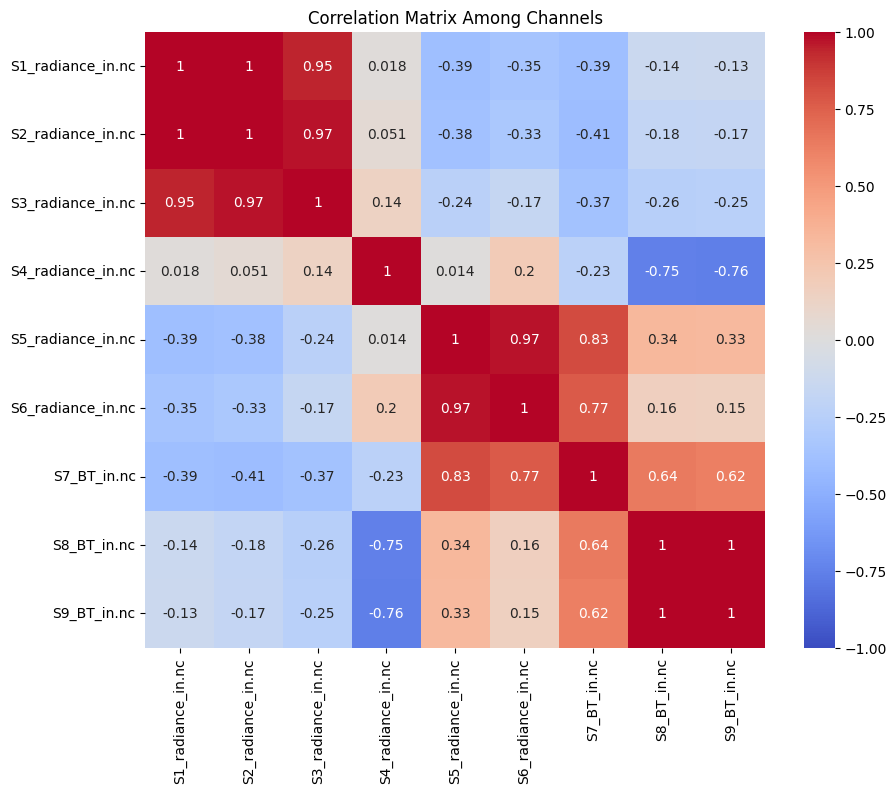

In [7]:
def plot_correlation_matrix(ds_combined):
    # Taking a smaller subset for correlation calculation
    subset = ds_combined[:, ::10, ::10].values
    reshaped_subset = subset.reshape(subset.shape[0], -1).T
    cleaned_subset = reshaped_subset[~np.isnan(reshaped_subset).any(axis=1)]
    
    correlation_matrix = np.corrcoef(cleaned_subset, rowvar=False)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title("Correlation Matrix Among Channels")
    plt.xticks(ticks=np.arange(len(channels)) + 0.5, labels=channels, rotation=90)
    plt.yticks(ticks=np.arange(len(channels)) + 0.5, labels=channels, rotation=0)
    plt.show()

plot_correlation_matrix(ds_combined)


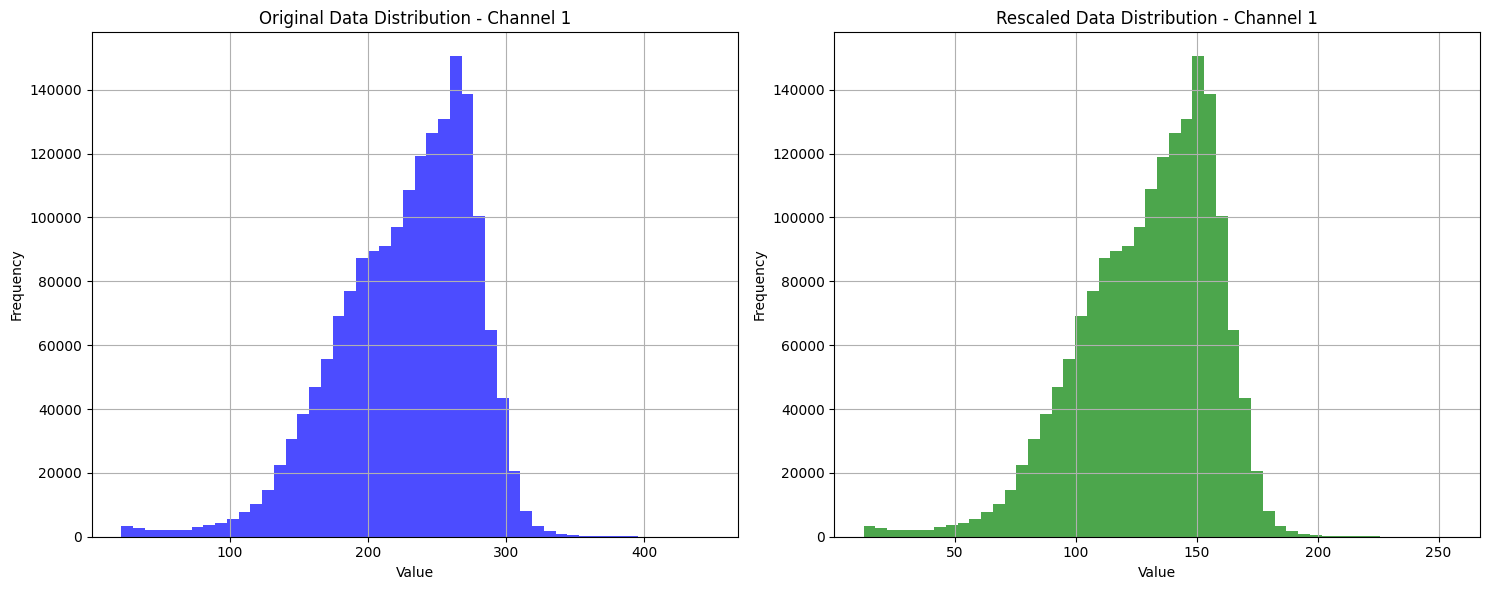

In [8]:
def plot_original_vs_rescaled(ds_combined, rescaled_data, channel_idx):
    original_data = ds_combined[channel_idx].values.flatten()
    rescaled = rescaled_data[channel_idx].values.flatten()
    valid_original = original_data[~np.isnan(original_data)]
    valid_rescaled = rescaled[~np.isnan(rescaled)]

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.hist(valid_original, bins=50, color='blue', alpha=0.7)
    plt.title(f"Original Data Distribution - Channel {channel_idx + 1}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.hist(valid_rescaled, bins=50, color='green', alpha=0.7)
    plt.title(f"Rescaled Data Distribution - Channel {channel_idx + 1}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Visualization for first channel
plot_original_vs_rescaled(ds_combined, rescaled_data, 0)


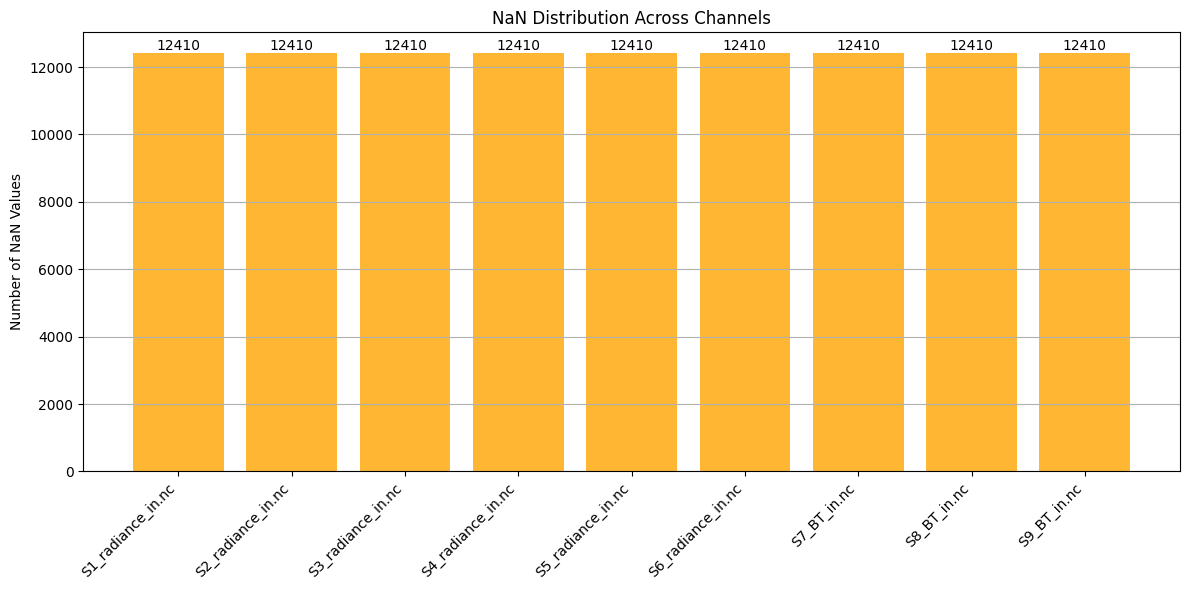

In [9]:
def plot_nan_distribution(ds_combined):
    nan_counts = [np.isnan(ds_combined[i].values).sum() for i in range(ds_combined.shape[0])]
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(channels, nan_counts, color='orange', alpha=0.8)
    plt.title("NaN Distribution Across Channels")
    plt.ylabel("Number of NaN Values")
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y")

    # Annotating each bar with its value
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

plot_nan_distribution(ds_combined)
